In [37]:
from bs4 import BeautifulSoup, NavigableString
from pathlib import Path
# import ray
import pandas as pd
import torch
import time
from transformers import AutoTokenizer, AutoModel
import pickle

In [64]:
EFS_DIR='dataset'
# Ray dataset
DOCS_DIR = Path(EFS_DIR, "docs.ray.io/en/master/")
input_data=[{"path": path} for path in DOCS_DIR.rglob("*.html") if not path.is_dir()]
# ds = ray.data.from_items(input_data)
df = pd.DataFrame(input_data)
print(f"{df.count()} documents")

path    3396
dtype: int64 documents


In [65]:
df.head()

,path
0,dataset/docs.ray.io/en/master/index.html
1,dataset/docs.ray.io/en/master/genindex.html
2,dataset/docs.ray.io/en/master/search.html
3,dataset/docs.ray.io/en/master/joblib.html
4,dataset/docs.ray.io/en/master/tune.html


In [66]:
def extract_text_from_section(section):
    texts = []
    for elem in section.children:
        if isinstance(elem, NavigableString):
            if elem.strip():
                texts.append(elem.strip())
        elif elem.name == "section":
            continue
        else:
            texts.append(elem.get_text().strip())
    return "\n".join(texts)

def path_to_uri(path, scheme="https://", domain="docs.ray.io"):
    return scheme + domain + str(path).split(domain)[-1]

def extract_sections(record):
    with open(record["path"], "r", encoding="utf-8") as html_file:
        soup = BeautifulSoup(html_file, "html.parser")
    sections = soup.find_all("section")
    section_list = []
    for section in sections:
        section_id = section.get("id")
        section_text = extract_text_from_section(section)
        if section_id:
            uri = path_to_uri(path=record["path"])
            section_list.append({"source": f"{uri}#{section_id}", "text": section_text})
    return section_list

In [67]:
sample_html_fp = Path(EFS_DIR, "docs.ray.io/en/master/rllib/rllib-env.html")
extract_sections({"path": sample_html_fp})[0]

{'source': 'https://docs.ray.io/en/master/rllib/rllib-env.html#environments',
 'text': '\nEnvironments#\nRLlib works with several different types of environments, including Farama-Foundation Gymnasium, user-defined, multi-agent, and also batched environments.\nTip\nNot all environments work with all algorithms. See the algorithm overview for more information.\n'}

In [68]:
# Extract sections
# sections_ds = ds.flat_map(extract_sections)
# sections_ds.count()
# sections = sections_ds.take_all()
# print (len(sections))
import time
s1=time.time()
data_processed0 = []
for dt in input_data:
    data_processed0.extend(extract_sections(dt))
print('Elapsed time: ', time.time()-s1)
# df

Elapsed time:  363.3840878009796


In [69]:
df = pd.DataFrame(data_processed0)
df.head()

,source,text
0,https://docs.ray.io/en/master/joblib.html#dist...,\nDistributed Scikit-learn / Joblib#\nRay supp...
1,https://docs.ray.io/en/master/joblib.html#quic...,"Quickstart#\nTo get started, first install Ray..."
2,https://docs.ray.io/en/master/joblib.html#run-...,Run on a Cluster#\nThis section assumes that y...
3,https://docs.ray.io/en/master/tune.html#ray-tu...,\nRay Tune: Hyperparameter Tuning#\n\n\nTune i...
4,https://docs.ray.io/en/master/tune.html#why-ch...,Why choose Tune?#\nThere are many other hyperp...


In [70]:
# section_lengths = []
# for section in sections_ds.take_all():
#     section_lengths.append(len(section["text"]))
section_lengths = []
for section in data_processed0:
    section_lengths.append(len(section['text']))

In [71]:
import warnings
warnings.filterwarnings("ignore")


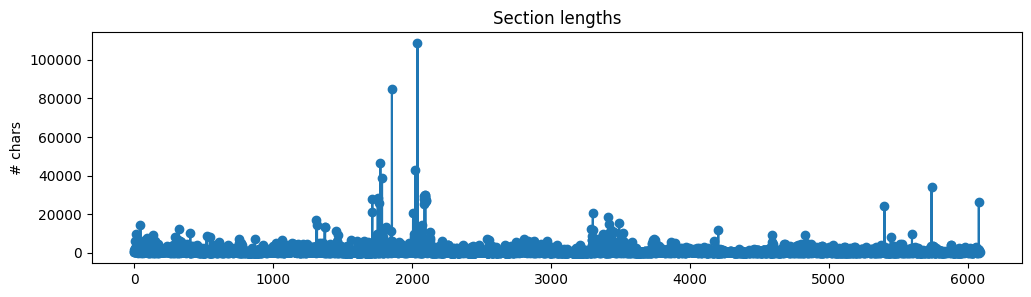

In [72]:
# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 3))
plt.plot(section_lengths, marker='o')
plt.title("Section lengths")
plt.ylabel("# chars")
plt.show()

In [73]:
from functools import partial
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [74]:
# Text splitter
chunk_size=300
chunk_overlap=50
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n","\n", " ", ""],
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    length_function=len
)

# Try one example for chunking

In [75]:
sample_section = data_processed0[0]
chunks = text_splitter.create_documents(
    texts=[sample_section['text']],
    metadatas=[{'source':sample_section['source']}]
)

In [76]:
print('length of text: ',len(sample_section['text']), '\n Number of chunks: ', len(chunks))

length of text:  404 
 Number of chunks:  2


In [77]:
print(chunks[0])

print('chunk\'s length:', len(chunks[0].page_content))

page_content='Distributed Scikit-learn / Joblib#
Ray supports running distributed scikit-learn programs by
implementing a Ray backend for joblib using Ray Actors
instead of local processes. This makes it easy to scale existing applications
that use scikit-learn from a single node to a cluster.
Note' metadata={'source': 'https://docs.ray.io/en/master/joblib.html#distributed-scikit-learn-joblib'}
chunk's length: 285


In [78]:
print(chunks[1])
print('chunk\'s length:', len(chunks[1].page_content))

page_content='Note
This API is new and may be revised in future Ray releases. If you encounter
any bugs, please file an issue on GitHub.' metadata={'source': 'https://docs.ray.io/en/master/joblib.html#distributed-scikit-learn-joblib'}
chunk's length: 122


# Chunkify all sections

In [79]:
def chunk_section(section, chunk_size, chunk_overlap):
    text_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", " ", ""],
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len)
#     import pdb; pdb.set_trace()
    chunks = text_splitter.create_documents(
        texts=[section['text']], 
        metadatas=[{"source": section["source"]}])
    return [{"text": chunk.page_content, "source": chunk.metadata["source"]} for chunk in chunks]

In [80]:
chunk_ds =df.apply(chunk_section,args=(chunk_size,chunk_overlap), axis=1)

In [81]:
print('# chunks: ',len(chunk_ds.head()[0]))
print('# chunks: ',len(chunk_ds.head()[1]))
print('# chunks: ',len(chunk_ds.head()[2]))
print('# chunks: ',len(chunk_ds.head()[4]))

# chunks:  2
# chunks:  6
# chunks:  3
# chunks:  10


In [88]:
import tiktoken

def count_tokens(row, model="gpt-3.5-turbo"):
    # Initialize the tokenizer for the specified model']
    encoding = tiktoken.encoding_for_model(model)
    
    # Encode the text to get the tokens
    tokens=[]
    for data in row:
        tokens.extend(encoding.encode(data['text']))
    
    # Return the number of tokens
    return len(tokens)

# # Example usage:
# chunk = "This is an example chunk of text."
# num_tokens = count_tokens(chunk)
# print(f"Number of tokens: {num_tokens}")



In [98]:
# chunk_ds.to_frame().columns
chunk_ds.apply(count_tokens).sum()


1623116

# Embed data

In [58]:
from transformers import AutoTokenizer, AutoModel
# model_name = 'thenlper/gte-small'
model_name = 'databricks/dolly-v2-3b'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)


In [59]:
def encode_sentence(sentences):
  # Tokenize the sentences
  encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
  # Generate embeddings
  with torch.no_grad():
    model_output = model(**encoded_input)

  # Pooling strategy (adjust as needed)
  sentence_embeddings = model_output.last_hidden_state[:,0,:] #pooler_output

  return sentence_embeddings

In [31]:
seg=len(chunk_ds)//100
for i in range(34,100):
    print('i: ',i,', start: ', seg*i, ', end: ',seg*(i+1))

In [32]:

def batch_process(sentences):
    texts = [item['text'] for item in sentences]
    sources = [item['source'] for item in sentences]
    embeddings = encode_sentence(texts)
    output=[]
#     import pdb; pdb.set_trace()
    for ii,src in enumerate(sources):
        output.append({"text":texts[ii],"source":sources[ii], "embedding":embeddings[ii]})
    return output
import pickle
def write_list(a_list,filename):
    with open(filename,'wb') as fp:
        pickle.dump(a_list,fp)

In [ ]:
embedded_chunks=[]
num_segs=100
seg=len(chunk_ds)//num_segs
for i in range(34,100):#range(num_segs):
    s1=time.time()
    embedded_chunks= chunk_ds[i*seg:(i+1)*seg].apply(batch_process)
    write_list(embedded_chunks,'embedding_seg'+str(i+1)+'.pkl')
    print("Elapsed time for seg ", str(i+1),": ", time.time()-s1)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
# out=batch_process(chunk_ds[0])


write_list(embedded_chunks)

In [10]:
def read_list(filename):
    with open(filename, 'rb') as fp:
        return pickle.load(fp)
ret1 = read_list('embedding_seg1.pkl')
ret2 = read_list('embedding_seg2.pkl')

In [33]:
ret1[0][0]['embedding'].shape

torch.Size([2560])

In [37]:
total_rets=[]
total_rets.extend(ret1)
total_rets.extend(ret2)
len(ret1), len(total_rets)

(60, 120)

In [47]:
count=0
for i in range(len(total_rets)):
    for j in range(len(total_rets[i])):
        total_rets[i][j]['text']
        total_rets[i][j]['embedding']
        total_rets[i][j]['source']
        count+=1
print(count)


811


# Vector DB

In [31]:
# !pip install pgvector-haystack
import psycopg
from pgvector.psycopg import register_vector

In [52]:
class pgvectorManager:
    def __init__(self, dbname='postgres', user='postgres',password_file=r'postgres_password.txt'):
        self.dbname=dbname
        self.user=user
        self.password=self.get_password(password_file)
        # Connect to postgres and create the vector extension
        if self.password is None:
            raise ValueError("Failed to retrieve te database password.")
            self.conn=psycopg.connect(dbname=self.dbname, autocommit=True, user=self.user, password=self.password)
            self.conn.execute('CREATE EXTENSION IF NOT EXISTS vector')
            register_vector(self.conn)
            self.vector_size=2560
            self.texts=None
            self.embeddings=None
        
    @staticmethod
    def get_password(password_file):
        try:
            with open(password_file,'r') as file:
                password = file.read().strip()
        except FileNotFoundError:
            print(f"The file '{password_file}' does not exist.")
            password=None
        except Exception as e:
            print(f"An error occurred: {e}")
            password=None
        return password
        
    def read_embedding_file(self,filename):
        with open(filename, 'rb') as fp:
            return pickle.load(fp)
    
    def create_embeddings(self):
        # read all embedding_segs and return them
        # self.embeddings = self.model.encode(texts)
        # self.vector_size = self.embeddings.shape[1]
        self.total_data=[]
        for i in range(100):
            self.total_data.extend(read_embedding_file('embedding_seg'+str(i+1)+'.pkl'))
        return self.total_data
        
    def create_documents_table(self):
        self.conn.execute('DROP TABLE IF EXISTS documents')
        self.conn.execute('CREATE TABLE documents (id bigserial PRIMARY KEY, content text, '
                          'embedding vector('+str(self.vector_size)+'))')
    
    
    def insert_documents(self):
        if self.total_data is None:# or len(self.texts)!=len(self.embeddings):
            raise ValueError("Mismatch between texts and embeddings. Ensure embeddings are created before inserting.")
            
        for i in range(len(total_data)):
            for j in range(len(total_dta[i])):
                total_data[i][j]['embedding']
                total_data[i][j]['source']
                self.conn.execute('INSERT INTO documents (text, source, embedding) VALUES (%s,%s,%s)', 
                                  (self.total_data[i][j]['text'], self.total_data[i][j]['source'], self.total_data[i][j]['embedding']))
#         for content, embedding in zip(self.texts, self.embeddings):
#             self.conn.execute('INSERT INTO documents (content, embedding) VALUES (%s,%s)', (content, embedding))
    
    def store_documents(self, data):
        self.create_embeddings()
        self.create_document_table()
        self.insert_documents()
    
    def find_neighbors(self, document_id=1):
        neighbors = self.conn.execute('SELECT *,(embedding<=>%s) AS similarity_score FROM documents ORDER BY similarity_score LIMIT %s', (embedding, num_chunks))
                                      #WHERE id != %(id)s ORDER BY embedding <=> '
#                                      'SELECT embedding from documents wher id=%(id)s) LIMIT5',
#                                      {'id':document_id}).fetchall()
        for neighbor in neghbors:
            print(neighbor[0])

#### Because vectorDB is not installed, we use faiss library

In [1]:
import pickle
def read_embedding_file(filename):
    with open(filename, 'rb') as fp:
        return pickle.load(fp)

In [2]:
from tqdm.notebook import tqdm

remove_list=[28,29,30,31,34,35]
total_data=[]
for i in tqdm(range(100)):
    if i+1 in remove_list: 
        continue
#     print('embedding_seg'+str(i+1)+'.pkl')
    total_data.extend(read_embedding_file('embedding_seg'+str(i+1)+'.pkl'))


  0%|          | 0/100 [00:00<?, ?it/s]

In [60]:
len(total_data)

395

In [34]:
# 1-28, 30=360, 32=369,33=705, 36=576, 37=193,38=219, 37=193, 38=219, 39=174, 40=207, 41=107, 42=142, 43=246, 44=153, 45=168, 46=334, 47=465, 48=421
# 49=360, 50=193, 51=247, 52=153, 53=128, 54=105, 55=328, 56=754, 57=614, 58=614, 59=609, 60=249, 61=95, 62=99, 63=511, 64=212
# 65=267, 66=197, 67=219, 68=216, 69=211, 70=210, 71=220, 72=127, 73=120, 74=90, 75=195, 76=138, 77=313, 78=175, 79=384,
#80=238, 81=353,82=229, 83=313, 84=226, 85=156, 86=193,87=208, 88=216, 89=204, 90=213, 91=312, 92=225, 93=225, 94=288
# 95=122, 96=380, 97=160, 98=99, 99=132, 100=201
# after storing the data in total_data list, we only use 5246 out of 5640 elements of list to fit data in the memory

In [5]:
import torch.utils.data as data
import torch
class MyDataset(data.Dataset):
    def __init__(self,data):
        self.data = data
        self.count=0
        self.Process_data()
        
    def __len__(self):
        return self.count
    
    def Process_data(self):
        self.total_data_text=[]
        self.total_data_source=[]
        self.total_data_embedding=[]
        
#         for elem in tqdm(self.data):
#         import pdb; pdb.set_trace()
        i=0
        while len(self.data)>0:
            if i==5245: break
            elem = self.data[0]
#             if i==5246: break # exit the for loop because of the lack of memory
            for j in range(len(elem)):
                self.total_data_source.append(elem[j]['source'])
                self.total_data_text.append(elem[j]['text'])
                self.total_data_embedding.append(elem[j]['embedding'])
                self.count+=1
            self.data.remove(elem)
            i+=1
            
#         for i in tqdm(range(len(self.data))):
# #             if i==5246: break # exit the for loop because of the lack of memory
#             for j in range(len(self.data[i])):
#                 self.total_data_source.extend(self.data[i][j]['source'])
#                 self.total_data_text.extend(self.data[i][j]['text'])
#                 self.total_data_embedding.extend(self.data[i][j]['embedding'])
#                 self.count+=1
#             self.data.remove(self.data[i])
    
    def __getitem__(self,idx):
        return torch.tensor(self.total_data_embedding[idx]), self.total_data_text[idx], self.total_data_source[idx]
    def __len__(self):
        return len(self.total_data_source)
        

In [6]:
from torch.utils.data import DataLoader
dataset = MyDataset(total_data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

### Build an Index via faiss

In [15]:
!pip install faiss-gpu

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 80.7 MB/s eta 0:00:0000:0100:01m


In [10]:
import faiss
embedding_dim = 2560
index = faiss.IndexFlatL2(embedding_dim)
for batch in dataloader:
    embeddings,_,_=batch
    index.add(embeddings.numpy())


<ipython-input-5-c975d8ce400d>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.total_data_embedding[idx]), self.total_data_text[idx], self.total_data_source[idx]


# Retrieval
WIth our embedded chunks indexed in faiss, we are ready to perform retrieval for a given query. We will start y using the same embedding model we used to embed our text chunks to embed incoming query.
### Embed the query

In [61]:
# query = "For multi-agent modules, what does RLlib implement?"#"What is the default batch size for map_batches?"
query="how does slurm deal with rerouting output? " # What does Ray do for returning multiple objects?"
your_query_embedding = encode_sentence(query)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [62]:
# Find 5 nearest neighbors
query_embedding = torch.tensor(your_query_embedding)
distances, indices = index.search(query_embedding.numpy(), k=5)  

<ipython-input-62-bdaeaa275886>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_embedding = torch.tensor(your_query_embedding)


### Find 5 nearest context and add to query

In [63]:
# Retrieve corresponding text and source
context = ""

for i,idx in enumerate(indices[0]):
    print("-------------------------------")
    text = dataset[idx][1]
    context+=text+"\n"
    source = dataset[idx][2]
    print(f"distance: {distances[0][i]}")
    print(f"Text: {text}, Source: {source}")
print("add query to context")
context+=query
print("************************** Context **************************")
print(context)

-------------------------------
distance: 5.030272731687546e-08
Text: how a stateful ConnectorV2 class has its states
(here the means and standard deviations of the individual observation items) coming from the different
EnvRunner instances a) merged into one common state and
then b) broadcast again back to the remote EnvRunner workers., Source: https://docs.ray.io/en/master/rllib/rllib-examples.html#connectors
-------------------------------
distance: 5.030272731687546e-08
Text: how many layers, what kind of filters, etc. They are defined before training, not learned., Source: https://docs.ray.io/en/master/tune/faq.html#what-are-hyperparameters
-------------------------------
distance: 1858.998046875
Text: what Ray uses internally for its Object Store). The -t and -i options here are required to support
interactive use of the container.
If you use a GPU version Docker image, remember to add --gpus all option. Replace <ray-version> with your target ray version in the following command:

<ipython-input-5-c975d8ce400d>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.total_data_embedding[idx]), self.total_data_text[idx], self.total_data_source[idx]


###### Retrieved texts/docs are not relevant. Perhaps, the reason is that the related documents do not exist in embedding list, because we removed some documents to fit embeddings in memory. The other thing can be related to model selection for embedding.

# Generation
We can now use the context to generate a response from our LLM. Without this relevant context that we retrieved, the LLM may not have been able to accurately answer our questions. And as our data grows, we can just as easily embed and index any new data and be able to retrieve it to answer the question

In [47]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig

In [48]:
model_name='google/flan-t5-base'
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer  = AutoTokenizer.from_pretrained(model_name, use_fast=True)

In [51]:
sentence_encoded = tokenizer(context, return_tensors='pt')
model_output = model.generate(sentence_encoded['input_ids'], max_new_tokens=50,)
output = tokenizer.decode(model_output[0], skip_special_tokens=True)
print(output)

# Ray programs are able to parallelize and distribute by leveraging an underlying Ray runtime.
